# Lab | Text Generation from Shakespeare's Sonnet

This notebook explores the fascinating domain of text generation using a deep learning model trained on Shakespeare's sonnets. 

The objective is to create a neural network capable of generating text sequences that mimic the style and language of Shakespeare.

By utilizing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers, this project aims to demonstrate how a model can learn and replicate the complex patterns of early modern English. 

The dataset used consists of Shakespeare's sonnets, which are preprocessed and tokenized to serve as input for the model.

Throughout this notebook, you will see the steps taken to prepare the data, build and train the model, and evaluate its performance in generating text. 

This lab provides a hands-on approach to understanding the intricacies of natural language processing (NLP) and the potential of machine learning in creative text generation.

Let's import necessary libraries

In [48]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np
import matplotlib.pyplot as plt

Let's get the data!

In [37]:
import requests
url = 'https://raw.githubusercontent.com/martin-gorner/tensorflow-rnn-shakespeare/master/shakespeare/sonnets.txt'
resp = requests.get(url)
with open('sonnets.txt', 'wb') as f:
    f.write(resp.content)

data = open('sonnets.txt').read()

corpus = data.lower().split("\n")

Step 1: Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts

In [38]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

Step 2: Calculate the Vocabulary Size

Let's figure out how many unique words are in your corpus. This will be the size of your vocabulary.

Calculate the length of tokenizer.word_index, add 1 to it and store it in a variable called total_words.

In [39]:
unique_words = tokenizer.word_index
total_words = len(unique_words) + 1

Create an empty list called input_sequences.

For each sentence in your corpus, convert the text into a sequence of integers using the tokenizer.
Then, generate n-gram sequences from these tokens.

Store the result in the list input_sequences.

In [40]:
input_sequence = []

input_sequences = tokenizer.texts_to_sequences(corpus)

# Function to create n-grams from a sequence
def create_n_grams(sequence, n):
    n_grams = []
    for i in range(len(sequence) - n + 1):
        n_gram = sequence[i:i+n]
        n_grams.append(n_gram)
    return n_grams

# Creating bigrams from sequences
n = 2
all_n_grams = [create_n_grams(seq, n) for seq in input_sequences]

Calculate the length of the longest sequence in input_sequences. Assign the result to a variable called max_sequence_len.

Now pad the sequences using pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre').
Convert it to a numpy array and assign the result back to our variable called input_sequences.

In [41]:
max_sequence_len = max(len(sequence) for sequence in input_sequences)

padded_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')
input_sequences = np.array(padded_sequences)

Prepare Predictors and Labels

Split the sequences into two parts:

- Predictors: All elements from input_sequences except the last one.
- Labels: The last element of each sequence in input_sequences.

In [42]:
# Initialize lists to store predictors and labels
predictors = []
labels = []

# Split each sequence
for sequence in padded_sequences:
    predictors.append(sequence[:-1])  # All elements except the last one
    labels.append(sequence[-1])      # Last element

# Convert to NumPy arrays if needed
predictors = np.array(predictors)
labels = np.array(labels)

print("Predictors:")
print(predictors[:5])

print("Labels:")
print(labels[:5])

Predictors:
[[   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    3    2  313 1375]]
Labels:
[878   0   0   0   4]


One-Hot Encode the Labels :

Convert the labels (which are integers) into one-hot encoded vectors. 

Ensure the length of these vectors matches the total number of unique words in your vocabulary.

Use ku.to_categorical() on labels with num_classes = total_words

Assign the result back to our variable labels.

In [43]:
# One-hot encode the labels ensuring the number of classes matches the total unique words
labels = ku.to_categorical(labels, num_classes=total_words)

# Pick one of the one-hot encoded vectors to check its length
vector_length = len(labels[0])

# Test if the vector length matches the unique word count
print(f"Length of one-hot vector: {vector_length}")
print(f"Total number of unique words: {total_words}")
print(f"Do they match? {'Yes' if vector_length == total_words else 'No'}")


Length of one-hot vector: 3375
Total number of unique words: 3375
Do they match? Yes


# Initialize the Model

Start by creating a Sequential model.

Add Layers to the Model:

Embedding Layer: The first layer is an embedding layer. It converts word indices into dense vectors of fixed size (100 in this case). Set the input length to the maximum sequence length minus one, which corresponds to the number of previous words the model will consider when predicting the next word.

Bidirectional LSTM Layer: Add a Bidirectional LSTM layer with 150 units. This layer allows the model to learn context from both directions (past and future) in the sequence. return_sequences=True

Dropout Layer: Add a dropout layer with a rate of 0.2 to prevent overfitting by randomly setting 20% of the input units to 0 during training.

LSTM Layer: Add a second LSTM layer with 100 units. This layer processes the sequence and passes its output to the next layer.

Dense Layer (Intermediate): Add a dense layer with half the total number of words as units, using ReLU activation. A regularization term (L2) is added to prevent overfitting.

Dense Layer (Output): The final dense layer has as many units as there are words in the vocabulary, with a softmax activation function to output a probability distribution over all words.

In [59]:
model = Sequential([

    Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_len - 1),
    Bidirectional(LSTM(150, return_sequences=True)),
    Dropout(0.2),
    LSTM(100),
    Dense(total_words // 2, activation='relu', kernel_regularizer=regularizers.l2(0.02)),
    Dense(total_words, activation='softmax')
    
])

# Compile the Model:

Compile the model using categorical crossentropy as the loss function, the Adam optimizer for efficient training, and accuracy as the metric to evaluate during training.

In [60]:
# Compile model with a lower learning rate
optimizer = Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print Model Summary:

Use model.summary() to print a summary of the model, which shows the layers, their output shapes, and the number of parameters.

In [63]:
model.build()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 10, 100)        │       337,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 10, 300)        │       301,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 300)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1687)           │       170,387 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3375)           │     5,697,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,999,463 (76.29 MB)

 Trainable params: 6,666,487 (25.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,332,976 (50.86 MB)

# Now train the model for 50 epochs and assign it to a variable called history.

Training the model with 50 epochs should get you around 40% accuracy.

You can train the model for as many epochs as you like depending on the time and computing constraints you are facing. Ideally train it for a larger amount of epochs than 50.

That way you will get better text generation at the end.

However, dont waste your time.

In [64]:
X = predictors
y = labels

history = model.fit(X, y, epochs=50, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.2637 - loss: 3.3851 - val_accuracy: 0.1214 - val_loss: 14.4914
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.2627 - loss: 3.3421 - val_accuracy: 0.1252 - val_loss: 14.6055
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.2809 - loss: 3.2604 - val_accuracy: 0.1252 - val_loss: 14.8541
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.2829 - loss: 3.2207 - val_accuracy: 0.1290 - val_loss: 14.8901
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.2912 - loss: 3.2590 - val_accuracy: 0.1290 - val_loss: 15.0873
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.2830 - loss: 3.1971 - val_accuracy: 0.1290 - val_loss: 15.1084
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3139 - loss: 3.1928 - val_accuracy: 0.1309 - val_loss: 15.1734
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.2968 - loss: 3.1991 - val_accuracy: 0.1

In [65]:
# Save the entire model to a file
model.save('model.h5')

In [66]:
# Try training for 60 epochs
history = model.fit(X, y, epochs=60, batch_size=64, validation_split=0.2, verbose=1)
model.save('model_60.h5')

Epoch 1/60
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5324 - loss: 2.3070 - val_accuracy: 0.1233 - val_loss: 18.7864
Epoch 2/60
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5579 - loss: 2.2271 - val_accuracy: 0.1252 - val_loss: 18.8292
Epoch 3/60
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5715 - loss: 2.2273 - val_accuracy: 0.1233 - val_loss: 18.9310
Epoch 4/60
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5456 - loss: 2.1981 - val_accuracy: 0.1195 - val_loss: 19.1449
Epoch 5/60
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5735 - loss: 2.2494 - val_accuracy: 0.1252 - val_loss: 19.2105
Epoch 6/60
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5797 - loss: 2.1595 - val_accuracy: 0.1271 - val_loss: 19.0880
Epoch 7/60
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5998 - loss: 2.1337 - val_accuracy: 0.1252 - val_loss: 19.0539
Epoch 8/60
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6012 - loss: 2.1558 - val_accuracy: 0.1

# Use plt from matplotlib to plot the training accuracy over epochs and the loss over epochs

First you will have to get the accuracy and loss data over epochs, you can do this by using methods on your model.

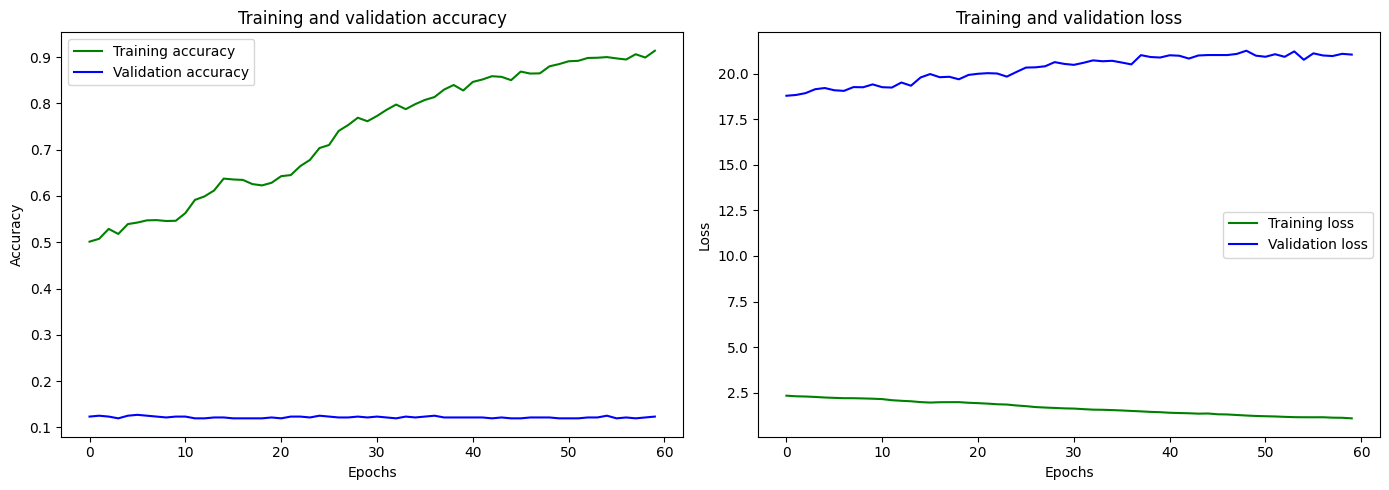

In [73]:
# Get training and validation metrics
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(training_accuracy, 'g-', label='Training accuracy')  # Green line for training
plt.plot(validation_accuracy, 'b-', label='Validation accuracy')  # Blue dashed line for validation
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, 'g-', label='Training loss')  # Green line for training
plt.plot(validation_loss, 'b-', label='Validation loss')  # Red dashed line for validation
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Generate text with the model based on a seed text

Now you will create two variables :

- seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
- next_words = number_of_words_you_want_the_model_to_generate

Please change number_of_words_you_want_the_model_to_generate by an actual integer.

In [77]:
# Define the seed text and number of words to generate
seed_text = "If music be the food of love"
next_words = 60

Now create a loop that runs based on the next_words variable and generates new text based on your seed_text input string. Print the full text with the generated text at the end.

This time you dont get detailed instructions.

Have fun!

In [78]:
# Initialize the generated text with the seed text
generated_text = seed_text

# Generate the specified number of words
for _ in range(next_words):
    # Tokenize and pad the current sequence
    token_list = tokenizer.texts_to_sequences([generated_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
    
    # Predict the next word
    predicted_probs = model.predict(token_list, verbose=0)
    predicted_index = np.argmax(predicted_probs, axis=-1)[0]
    
    # Find the word corresponding to the predicted index
    for word, index in tokenizer.word_index.items():
        if index == predicted_index:
            next_word = word
            break
    
    # Append the predicted word to the generated text
    generated_text += " " + next_word

print(generated_text)

If music be the food of love mute leaves fled burn due chest sorrow sky foes foes flatter foes halt foes foes foes flatter foes foes flatter flatter due both both both both ' cover ' it it thee own thee boast wit eyes alone light light light forth morn shine weep due chest due chest due chest due had lose lose back see crown'd crown'd where


Experiment with at least 3 different seed_text strings and see what happens!

In [79]:
# Define the seed text and number of words to generate
seed_text = "All the world's a stage"
next_words = 60

# Initialize the generated text with the seed text
generated_text = seed_text

# Generate the specified number of words
for _ in range(next_words):
    # Tokenize and pad the current sequence
    token_list = tokenizer.texts_to_sequences([generated_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
    
    # Predict the next word
    predicted_probs = model.predict(token_list, verbose=0)
    predicted_index = np.argmax(predicted_probs, axis=-1)[0]
    
    # Find the word corresponding to the predicted index
    for word, index in tokenizer.word_index.items():
        if index == predicted_index:
            next_word = word
            break
    
    # Append the predicted word to the generated text
    generated_text += " " + next_word

print(generated_text)

All the world's a stage fade desire gone eyes mine date date light crown'd i where appear posterity rehearse crime hours tend you say eye skill men tongue ill sight song thence cover thee ' thee ' thee ' thee show alone forth song art tongue shade eyes wit live say thee thee waste now now now mind live thee thee it waste live one


In [80]:
# Define the seed text and number of words to generate
seed_text = "Once more unto the breach"
next_words = 60

# Initialize the generated text with the seed text
generated_text = seed_text

# Generate the specified number of words
for _ in range(next_words):
    # Tokenize and pad the current sequence
    token_list = tokenizer.texts_to_sequences([generated_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
    
    # Predict the next word
    predicted_probs = model.predict(token_list, verbose=0)
    predicted_index = np.argmax(predicted_probs, axis=-1)[0]
    
    # Find the word corresponding to the predicted index
    for word, index in tokenizer.word_index.items():
        if index == predicted_index:
            next_word = word
            break
    
    # Append the predicted word to the generated text
    generated_text += " " + next_word

print(generated_text)

Once more unto the breach were ear confounds dispense controlling less nought back come out i light men men men sight tongue own crown'd crown'd forth tongue blot tongue own crown'd you this this thence burn flatter ' thee thence took ' thee ' thee ' you now mind live thee me say thee waste now now live live night thee me now waste now
